### Project 31 - Porto Seguro’s Safe Driver Prediction - Predict if a driver will file an insurance claim next year.
# Phase 5: Deployment and Productionization

**In this phase of Deployment and Productionization, we will do the below activities:**

1. Save our best model - Elastic Net Logistic Regression
2. Evaluate our best model using the kaggle test data to get Normalized Gini Score, and our ranking
3. Make a predictive system which performs the prediction for a single observation, and deploy the model using streamlit cloud
4. Make a predictive system which performs the prediction more than one observations stored in csv file, and deploy the model using streamlit cloud

## Save the final (winning) model - Elastic Net Logistic Regression

Import the required libraries

In [4]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)

# Pickle for reading model files
import pickle

# Scikit-Learn's train_test_split function
from sklearn.model_selection import train_test_split

# Area Under ROC Curve
from sklearn.metrics import roc_curve, roc_auc_score

# scikitlearn
import sklearn
sklearn.set_config(print_changed_only = False)

# Ignore sklearn's FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#Ignore Pandas SettingWithCopyWarning 
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import pprint

Load the 'winning' Elastic Net Logistic Regression Model from the disk

In [5]:
filename = 'enet_model.sav'
enet_model = pickle.load(open(filename, 'rb'))

Print Our best estimator

In [6]:
pprint.pprint(enet_model.best_estimator_)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1000, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=0.1, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='elasticnet', random_state=123,
                                    solver='saga', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)


In [7]:
# Save winning model as final_model.pkl
with open('final_model.pkl','wb') as f:
    pickle.dump(enet_model.best_estimator_, f)

## Evaluate the final (winning) model using kaggle.com test data

Load **final_model.pkl** as model

In [8]:
# Load final_model.pkl as model
with open('final_model.pkl', 'rb') as f:
    clf = pickle.load(f)

Load the test dataset

In [9]:
test_df = pd.read_csv('Dataset/test.csv')
print(test_df.shape)

(892816, 58)


Pre-process the test dataset

In [10]:
# Separate the id from the test dataset
id_df = test_df['id']

# Choose only the feature-selection columns of the test dataset into X_df
reqd_features = ['ps_calc_02', 'ps_ind_12_bin', 'ps_ind_07_bin', 'ps_ind_15', 'ps_car_08_cat', 'ps_car_02_cat', 'ps_car_13', 
                 'ps_car_07_cat', 'ps_car_04_cat', 'ps_car_14', 'ps_ind_02_cat', 'ps_ind_17_bin', 'ps_car_11', 'ps_ind_18_bin', 
                 'ps_car_12', 'ps_ind_04_cat', 'ps_reg_03', 'ps_reg_01', 'ps_car_15', 'ps_calc_01', 'ps_car_09_cat', 
                 'ps_ind_14', 'ps_ind_16_bin', 'ps_ind_05_cat', 'ps_ind_11_bin', 'ps_ind_01', 'ps_reg_02', 'ps_ind_08_bin', 
                 'ps_car_10_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_01_cat', 'ps_car_06_cat', 'ps_calc_03', 
                 'ps_ind_10_bin', 'ps_ind_06_bin', 'ps_ind_03', 'ps_ind_09_bin']

X_df = test_df[reqd_features]

Make the predictions (using the final model 'clf')

In [11]:
# Predict PROBABILITIES using final model (clf) ENet Logistic Regression
X_pred_prob = clf.predict_proba(X_df)

# Get JUST the PREDICTION PROBABILITY for positive class
X_pred_prob = [ p[1] for p in X_pred_prob ]

Save the predictions to a dataframe along with the 'id' column

In [12]:
X_pred_prob = pd.DataFrame(X_pred_prob)

# merge id and target to a single dataframe
result_df = pd.concat([id_df, X_pred_prob], axis = 1, ignore_index=True)
result_df.columns =['id', 'target']

In [13]:
result_df.head()

,id,target
0,0,0.028421
1,1,0.028427
2,2,0.026787
3,3,0.018899
4,4,0.032291


In [14]:
# Save the results_df dataframe to a new file
result_df.to_csv('Output/final_model_output.csv', index=None)

## Upload the output file in kaggle to get the Evaluation score

Uploading the output file in kaggle submission gives a **private score = 0.24857**, while the **kaggle leader private score is 0.29698**.
And **public score = 0.24195**, while the **kaggle leader public score is 0.29154**.

Rank for the private score of 0.24857 is **4227** out of 5158 submissions, which is in **81.9%**

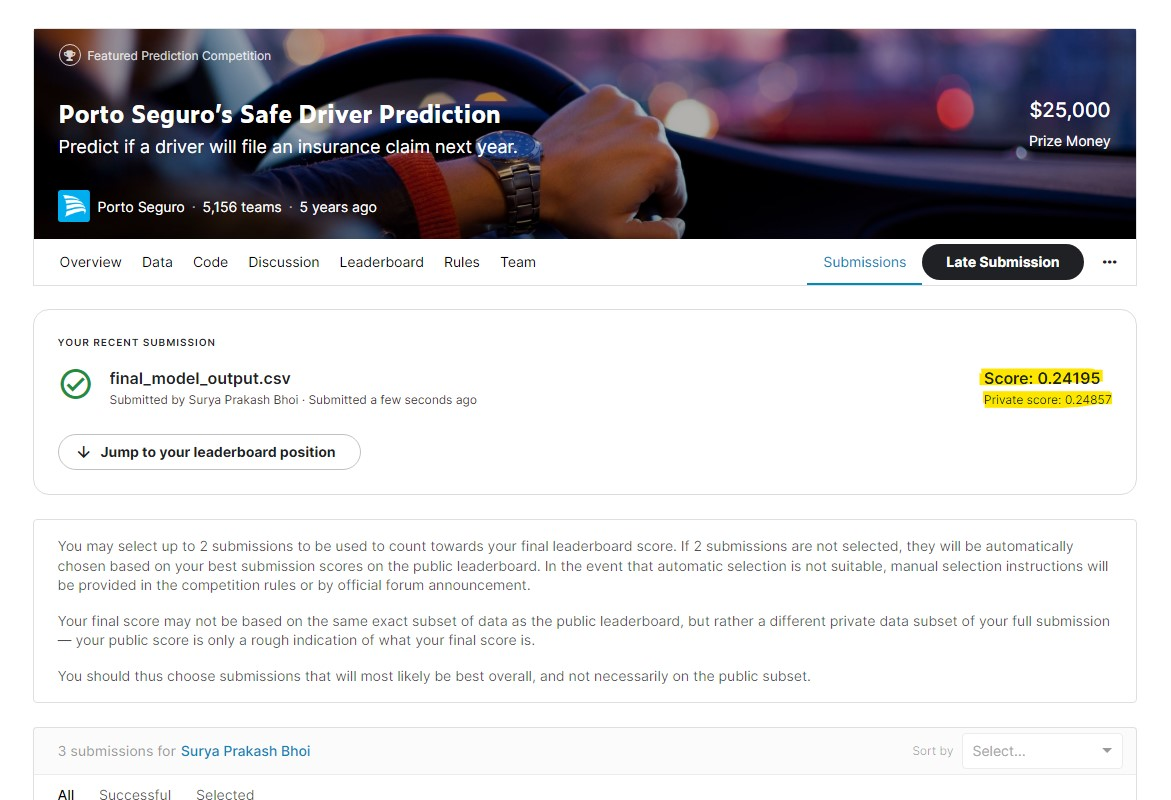

## Making a predicitve system where the user predicts for a single observation

Helper Function to take a **single observation and predict if the driver will make an insurance claim next year**

In [24]:
def fn_insurance_claim_prediction(input_data):    
    # changing the input_data to numpy array
    input_data_as_numpy_array = np.asarray(input_data)
    
    #required fields from the input data (in specific order)
    needed_cols = [39,12,7,15,29,23,35,28,25,36,2,17,33,18,34,4,21,19,37,38,
                   30,14,16,5,11,1,20,8,31,24,26,22,27,40,10,6,3,9]
    input_data_list = input_data_as_numpy_array[needed_cols]
    
    # cahnge to numpy array
    input_data = np.asarray(input_data_list)
    
    # reshape the array as we are predicting for one instance
    input_data_reshaped = input_data.reshape(1,-1)
    
    # Make the prediction
    prediction = (clf.predict_proba(input_data_reshaped)[:,1] >= 0.035).astype(int)
    #print(prediction)
    
    if (prediction[0] == 0):
      return 'The driver will not file an insurance claim next year'
    else:
      return 'The driver will file an insurance claim next year'

Test for a **positive** prediction

In [25]:
# This is an observation from test.csv file (which excludes target field)
user_input = (11,1,1,6,0,0,0,0,0,1,0,0,0,0,0,7,0,1,0,0.9,1.0,-1.0,11,0,-1,0,-1,
              4,1,1,2,1,104,2,0.44721359549999995,1.0413357601,0.4224926035,3.4641016150999997,
              0.0,0.9,0.7,2,1,7,1,9,1,11,6,1,6,10,0,1,1,0,0,0)

claim_prediciton = fn_insurance_claim_prediction(user_input)
print(claim_prediciton)

The driver will file an insurance claim next year


Test for a **negative** prediction

In [26]:
# This is an observation from test.csv file (which excludes target field)
user_input = (0,0,1,8,1,0,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.6103277807999999,
              7,1,-1,0,-1,1,1,1,2,1,65,1,0.316227766,0.6695564092,0.3521363372,3.4641016150999997,
              0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1)

claim_prediciton = fn_insurance_claim_prediction(user_input)
print(claim_prediciton)

The driver will not file an insurance claim next year


## Making a predicitve system where the user predicts for more than one observations stored in csv file

Read the **csv file** containing the observartions for which predcitions are to be made

In [32]:
test_df = pd.read_csv(
            'https://raw.githubusercontent.com/suryapbhoi/streamlit-insurance-bulk-claim-prediction-app/main/test_subset.csv'
            ,on_bad_lines='skip')

**Pre-processing steps** for the observations in the csv file

In [33]:
# Separate the id from the test dataset
id_df = test_df['id']

# Choose only the feature-selection columns of the test dataset into X_df
reqd_features = ['ps_calc_02', 'ps_ind_12_bin', 'ps_ind_07_bin', 'ps_ind_15', 'ps_car_08_cat', 'ps_car_02_cat', 'ps_car_13', 
                 'ps_car_07_cat', 'ps_car_04_cat', 'ps_car_14', 'ps_ind_02_cat', 'ps_ind_17_bin', 'ps_car_11', 'ps_ind_18_bin', 
                 'ps_car_12', 'ps_ind_04_cat', 'ps_reg_03', 'ps_reg_01', 'ps_car_15', 'ps_calc_01', 'ps_car_09_cat', 
                 'ps_ind_14', 'ps_ind_16_bin', 'ps_ind_05_cat', 'ps_ind_11_bin', 'ps_ind_01', 'ps_reg_02', 'ps_ind_08_bin', 
                 'ps_car_10_cat', 'ps_car_03_cat', 'ps_car_05_cat', 'ps_car_01_cat', 'ps_car_06_cat', 'ps_calc_03', 
                 'ps_ind_10_bin', 'ps_ind_06_bin', 'ps_ind_03', 'ps_ind_09_bin']

required_test_df = test_df[reqd_features]


**Predictions for all the observations** in the csv file

In [34]:
prediction = (clf.predict_proba(required_test_df)[:,1] >= 0.035).astype(int)
prediction_df = pd.DataFrame(prediction)

result_df = pd.concat([test_df, prediction_df], axis = 1, ignore_index=True)
result_df.columns = ['id','ps_ind_01','ps_ind_02_cat','ps_ind_03','ps_ind_04_cat','ps_ind_05_cat','ps_ind_06_bin',
                     'ps_ind_07_bin','ps_ind_08_bin','ps_ind_09_bin','ps_ind_10_bin','ps_ind_11_bin','ps_ind_12_bin',
                     'ps_ind_13_bin','ps_ind_14','ps_ind_15','ps_ind_16_bin','ps_ind_17_bin','ps_ind_18_bin',
                     'ps_reg_01','ps_reg_02','ps_reg_03','ps_car_01_cat','ps_car_02_cat','ps_car_03_cat','ps_car_04_cat',
                     'ps_car_05_cat','ps_car_06_cat','ps_car_07_cat','ps_car_08_cat','ps_car_09_cat','ps_car_10_cat',
                     'ps_car_11_cat','ps_car_11','ps_car_12','ps_car_13', 'ps_car_14','ps_car_15','ps_calc_01',
                     'ps_calc_02','ps_calc_03','ps_calc_04','ps_calc_05','ps_calc_06','ps_calc_07','ps_calc_08',
                     'ps_calc_09','ps_calc_10','ps_calc_11','ps_calc_12','ps_calc_13','ps_calc_14','ps_calc_15_bin',
                     'ps_calc_16_bin','ps_calc_17_bin', 'ps_calc_18_bin','ps_calc_19_bin','ps_calc_20_bin','target']

result_df.head(10)

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,target
0,0,0,1,8,1,0,0,1,0,0,0,0,0,0,0,12,1,0,0,0.5,0.3,0.610328,7,1,-1,0,-1,1,1,1,2,1,65,1,0.316228,0.669556,0.352136,3.464102,0.1,0.8,0.6,1,1,6,3,6,2,9,1,1,1,12,0,1,1,0,0,1,0
1,1,4,2,5,1,0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,0.5,0.771362,4,1,-1,0,0,11,1,1,0,1,103,1,0.316228,0.606320,0.358329,2.828427,0.4,0.5,0.4,3,3,8,4,10,2,7,2,0,3,10,0,0,1,1,0,1,0
2,2,5,1,3,0,0,0,0,0,1,0,0,0,0,0,10,0,0,0,0.4,0.0,0.916174,11,1,-1,0,-1,14,1,1,2,1,29,3,0.400000,0.896239,0.398497,3.316625,0.6,0.6,0.6,2,3,7,4,6,3,12,4,0,2,4,0,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,0,0,0,0,0,4,1,0,0,0.1,0.2,-1.000000,7,1,-1,0,-1,1,1,1,2,1,40,2,0.374166,0.652110,0.381445,2.449490,0.1,0.5,0.5,2,1,7,3,12,1,13,5,1,0,5,1,0,1,0,0,0,0
4,4,5,1,7,0,0,0,0,0,1,0,0,0,0,0,4,1,0,0,0.9,0.4,0.817771,11,1,-1,0,-1,11,1,1,2,1,101,3,0.374166,0.812914,0.385097,3.316625,0.9,0.6,0.8,3,4,7,1,10,4,12,4,0,0,4,0,1,1,0,0,1,0
5,5,0,1,6,0,0,1,0,0,0,0,0,0,0,0,10,1,0,0,0.9,0.5,0.759934,9,1,-1,0,-1,11,0,0,2,1,11,2,0.316228,0.750922,0.368782,3.605551,0.7,0.9,0.4,2,1,9,5,9,4,12,8,1,4,9,1,0,1,0,1,0,0
6,6,0,1,3,0,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.1,0.1,-1.000000,6,1,-1,0,0,1,1,1,0,1,10,2,0.316228,0.724569,0.381445,3.316625,0.9,0.8,0.8,1,1,7,3,9,5,6,2,0,4,6,1,1,0,0,0,0,0
7,8,0,1,0,0,0,1,0,0,0,0,0,0,0,0,7,1,0,0,0.9,1.1,1.145917,7,1,-1,0,-1,11,1,1,2,1,103,3,0.316228,0.586610,0.358329,2.645751,0.8,0.9,0.5,2,2,8,4,11,2,8,3,1,4,9,0,1,0,0,0,0,0
8,10,0,1,7,0,0,0,1,0,0,0,0,0,0,0,6,1,0,0,0.4,0.0,0.597390,11,0,1,1,0,2,-1,0,0,1,104,2,0.447214,1.640147,0.367423,3.741657,0.9,0.3,0.0,2,2,9,7,9,0,10,5,1,4,6,0,0,1,0,0,0,1
9,11,1,1,6,0,0,0,0,0,1,0,0,0,0,0,7,0,1,0,0.9,1.0,-1.000000,11,0,-1,0,-1,4,1,1,2,1,104,2,0.447214,1.041336,0.422493,3.464102,0.0,0.9,0.7,2,1,7,1,9,1,11,6,1,6,10,0,1,1,0,0,0,1


## Deploy the predicitve system which predicts a single observation

Deployment performed in streamlit cloud share platform

Application URL: https://suryapbhoi-streamlit--insurance-claim-prediction-web-app-segb5p.streamlitapp.com/ 

Github URL: https://github.com/suryapbhoi/streamlit-insurance-claim-prediction-app 

**Application Landing page screenshot:**

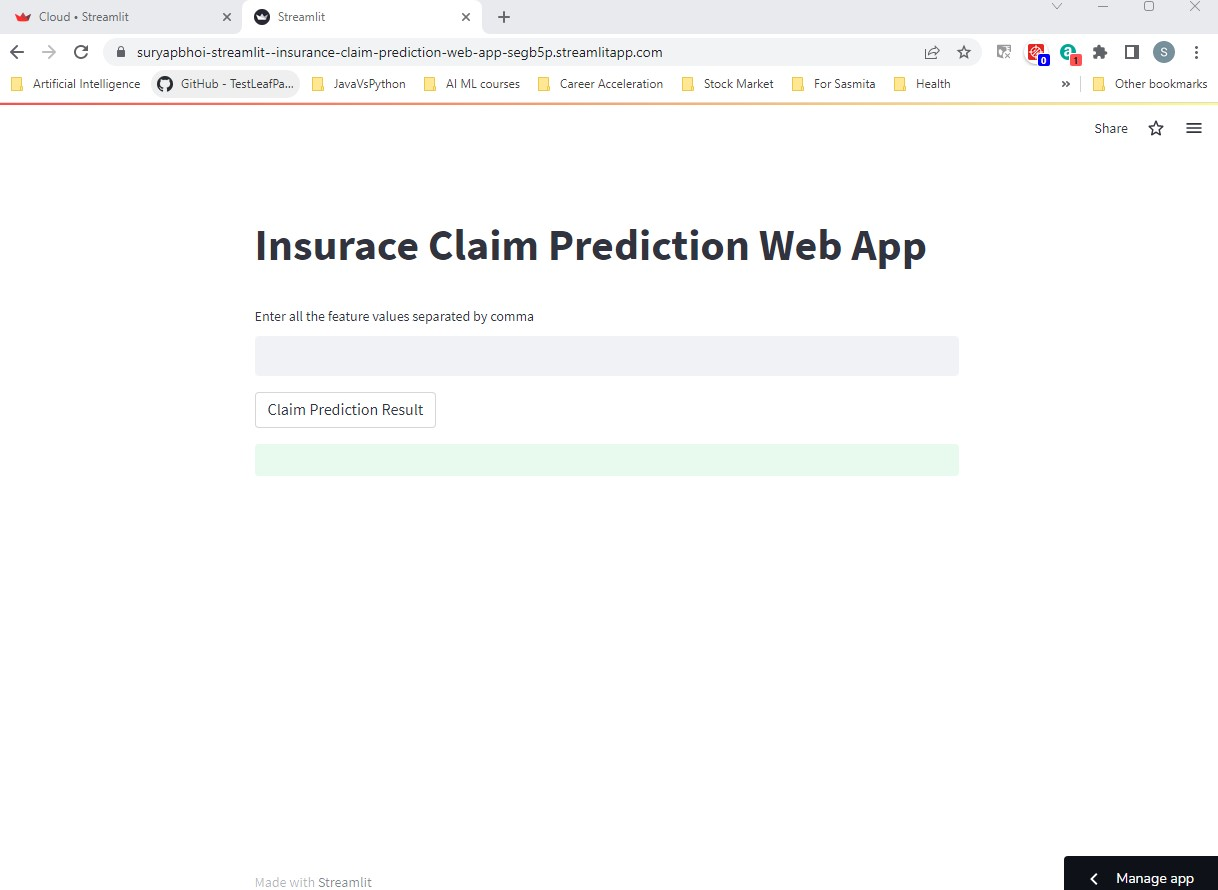




**Prediction result screenshot:**

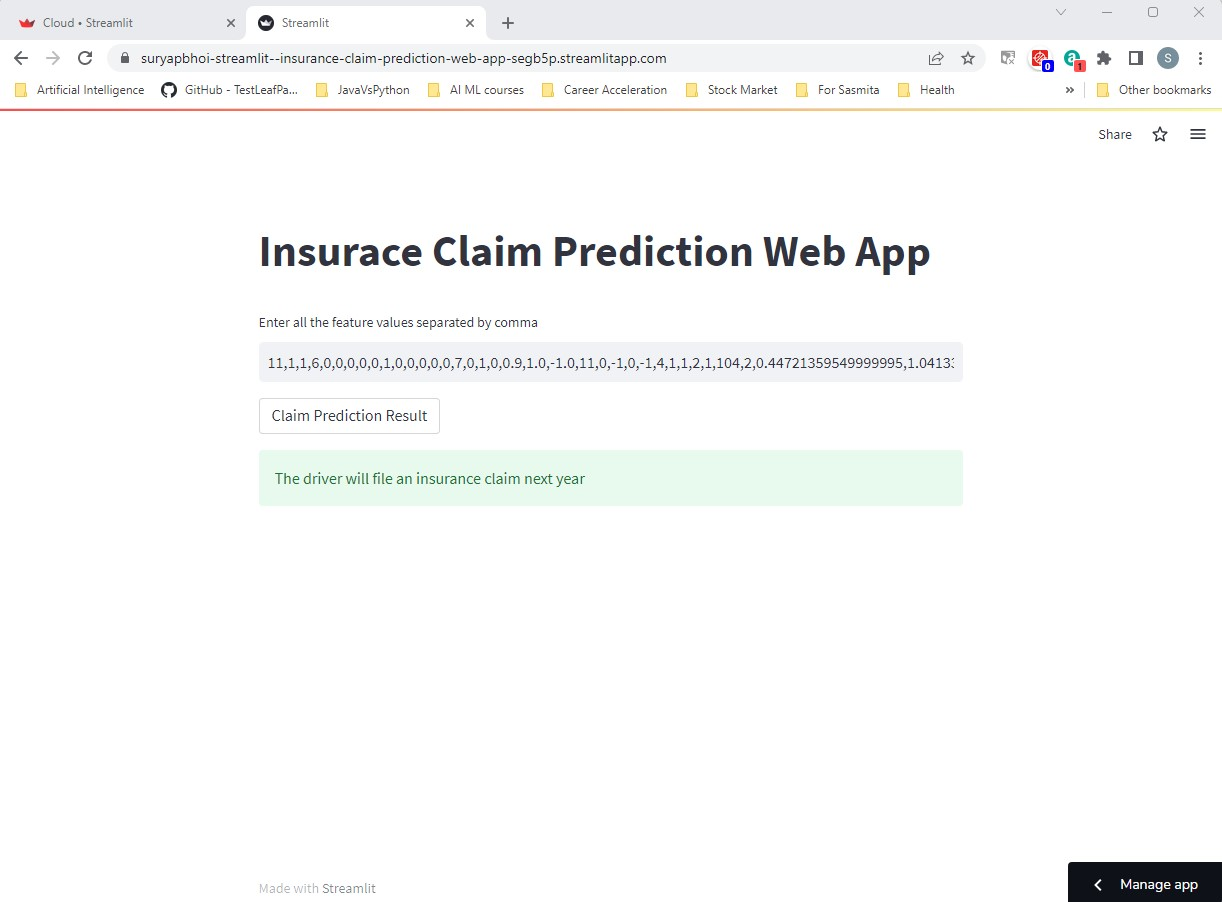

## Deploy the predicitve system which predicts more than one observation stored in csv file

Deployment performed in streamlit cloud share platform

Application URL: https://suryapbhoi-strea-insurance-claim-bulk-prediction-web-app-4l5c3u.streamlitapp.com/

Github URL: https://github.com/suryapbhoi/streamlit-insurance-bulk-claim-prediction-app

Test file used: https://raw.githubusercontent.com/suryapbhoi/streamlit-insurance-bulk-claim-prediction-app/main/test_subset.csv

**Application Landing page screenshot:**

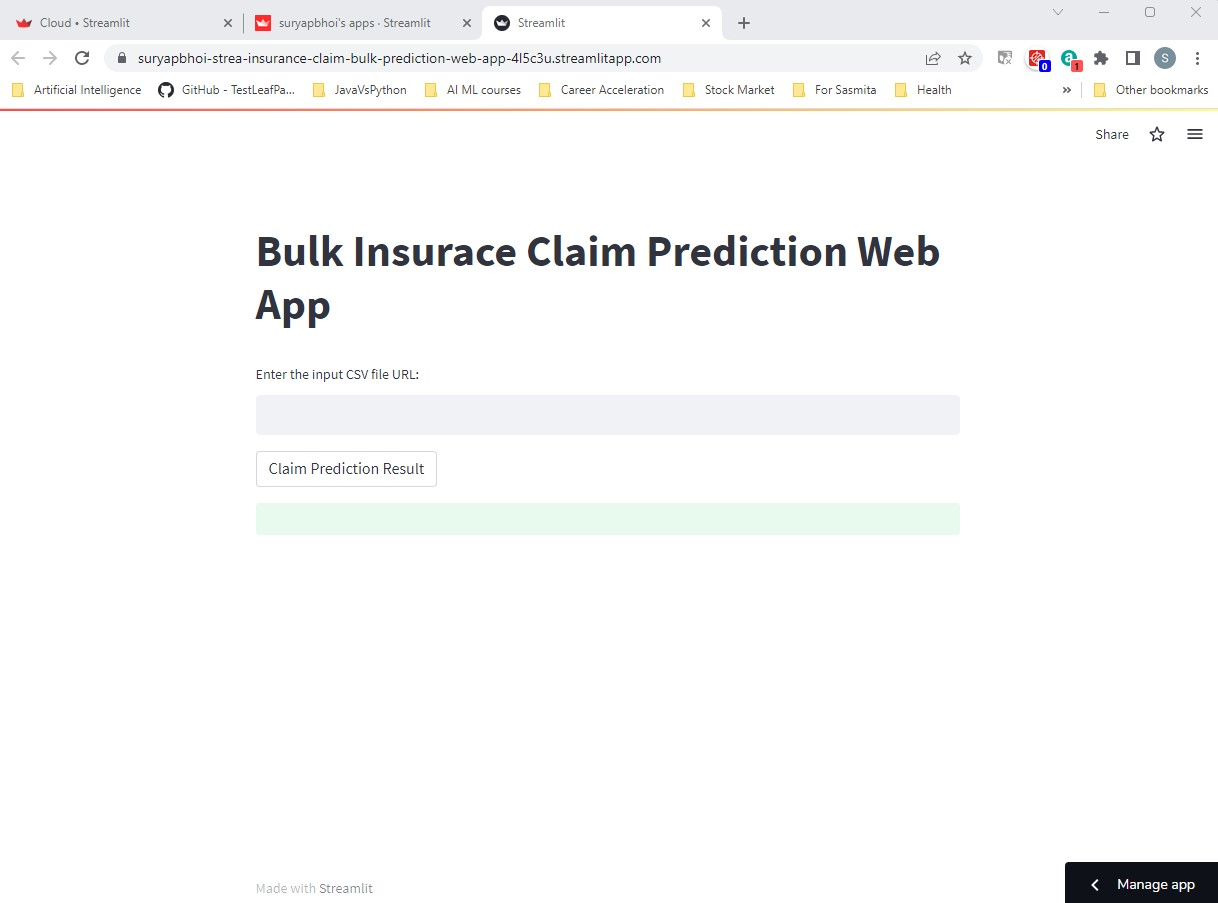

**Application Prediction done screenshot:**

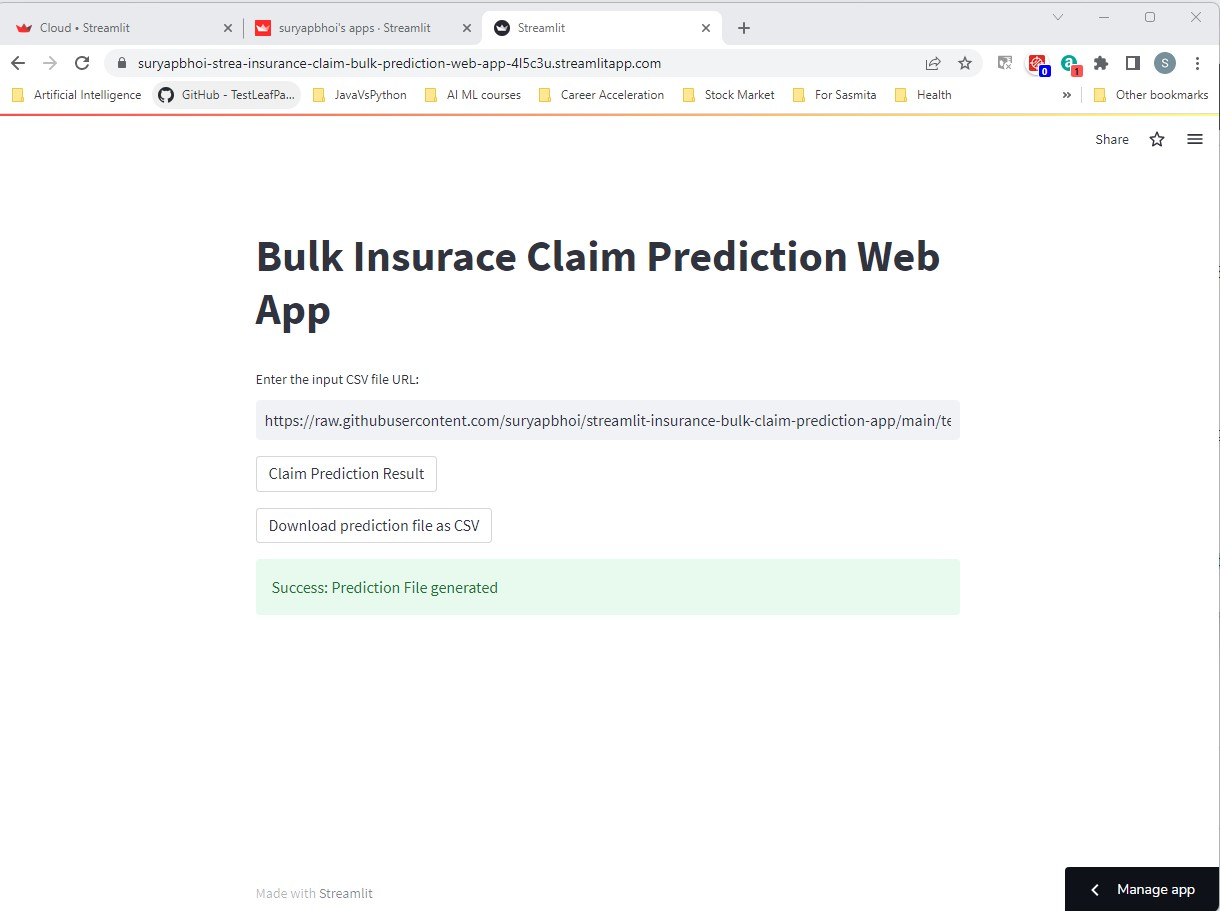

**Application Prediction file download screenshot:**

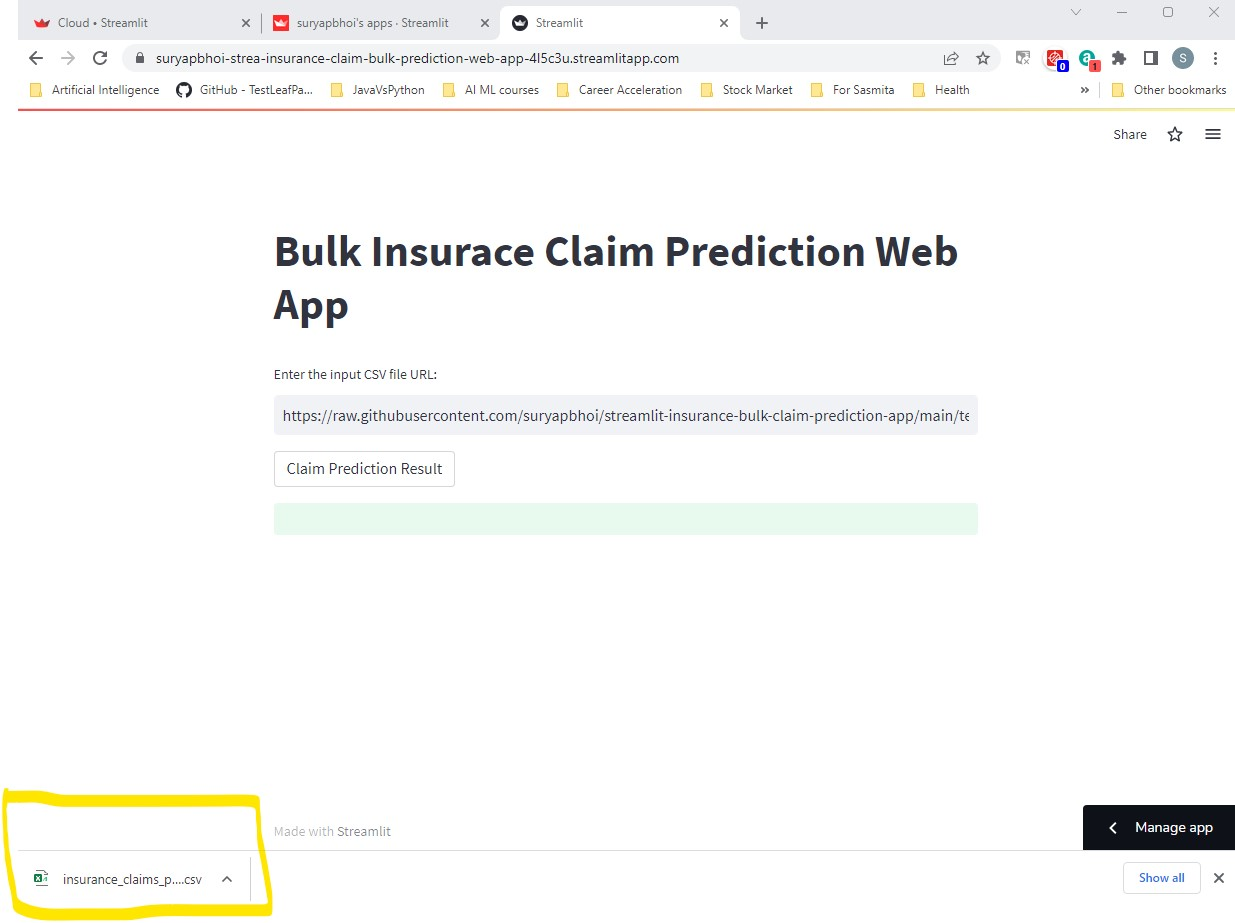